In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import PIL
from PIL import Image
import os

uint8


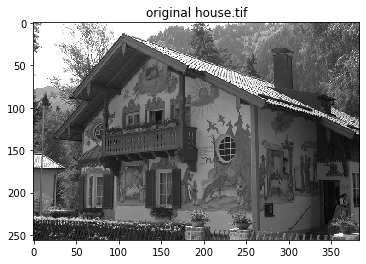

In [2]:
img = Image.open('house.tif') #PIL image
#convert img to numpy:
img_np = np.uint8(img)
plt.imshow(img_np, cmap='gray', interpolation = 'none')
plt.title('original house.tif')
img_np.shape
print(img_np.dtype)

Text(0.5, 1.0, 'Result of Thresholding T > 127 on house.tif')

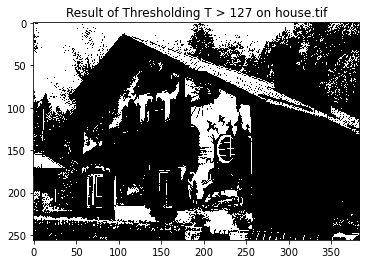

In [3]:
#apply threshold to img_np
T = 127 #threshold
img_binary = np.zeros((256,384))
for i in range(img_np.shape[0]):
    for j in range(img_np.shape[1]):
        if img_np[i,j] > 127:
            img_binary[i,j] = 255

plt.imshow(img_binary, cmap='gray' ,interpolation = 'none')
plt.title('Result of Thresholding T > 127 on house.tif')
#print(img_binary.dtype)

In [4]:
#compute the RMSE between original and binary images: RMSE = np.sqrt(1/NM * sum of errors on a pixel basis squared)

def computeRMSE(img_np, img_binary):
    """
    img_np is the original image while img_binary is the binary image. We want to compute the RMSE 
    on a px by px basis! 
    """
    error_sum = 0
    img_binary = img_binary.astype(np.double)
    img_np     = img_np.astype(np.double)
#    print(img_np.dtype)
    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            error_squared = np.square(img_np[i,j] - img_binary[i,j])
            error_sum = error_sum + error_squared


    N = img_np.shape[0]
    M = img_np.shape[1]
    NM = N*M


    RMSE = np.sqrt(error_sum / NM)
    print("RMSE is", RMSE)

computeRMSE(img_np, img_binary)



RMSE is 87.3933165438293


In [5]:
#Compute the image fidelity, which is defined as np.sqrt(1/NM * sum of (f~(i,j) - b~(i,j))^2
#to compute f~ and g~, you need to un-gamma correct f and b with gamma = 2.2
#then, LPF f and b using a 7 x 7 Gaussian filter. 

#first, do un-gammma correction for original and binary image!
def computeFidelity(img_np, img_binary, plot, gamma):
    #For original (img_np)
    un_gamma_orig = 255 * (img_np / 255)** gamma

    #For binary image (img_binary)

    un_gamma_binary = 255 * (img_binary / 255)** gamma

    #Now, apply LPF to un_gamma_orig and un_gamma_binary using 7 x 7 Gaussian filter 

    filt = np.zeros((7,7))
    sigma = np.sqrt(2)
    for m in range(7):
        for n in range(7):
            filt[m,n] = np.exp(-((m-3)**2 + (n-3)**2) / (2 * sigma**2) )
    filt = filt / np.sum(filt)
    #print(filt)

    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            if (i > 3) and (j > 3) and (i < img_np.shape[0]-3) and (j < img_np.shape[1] - 3):
                #apply filter:
                input_signal_un_gamma_orig = un_gamma_orig[i-3 :i + 4, j - 3: j+ 4] #7 x 7 window:
                #print(input_signal_un_gamma_orig.shape)
                #print('grabbing px centered at ', i, j)
                un_gamma_orig[i,j] = np.sum(input_signal_un_gamma_orig * filt) #filter the ungamma orig

                input_signal_un_gamma_binary = un_gamma_binary[i-3 :i + 4, j - 3: j+ 4] #7x 7 window of binary img
                un_gamma_binary[i,j] = np.sum(input_signal_un_gamma_binary * filt) #filter the ungamma binary



    #Apply transformation y = 255 * (x/255) ^ (1/3) for each pixel of the filtered images:
    un_gamma_orig_transformed = 255 * (un_gamma_orig / 255) ** (1/3)
    un_gamma_binary_transformed = 255 * (un_gamma_binary / 255) ** (1/3)

    # Plot images:
    if (plot == True):
        fig, ax = plt.subplots(2,2, figsize=(15,15))
        ax[0,0].imshow(un_gamma_orig, cmap='gray', interpolation = 'none')
        ax[0,0].set_title('orig filtered')
        ax[1,0].imshow(un_gamma_binary, cmap='gray', interpolation = 'none')
        ax[1,0].set_title('binary filtered')
        ax[0,1].imshow(un_gamma_orig_transformed, cmap='gray', interpolation = 'none')
        ax[0,1].set_title('orig filtered and transformed')
        ax[1,1].imshow(un_gamma_binary_transformed, cmap='gray', interpolation = 'none')
        ax[1,1].set_title('binary filtered and transformed')
    
    #compute fidelity:
    error_sum = 0
    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            error_squared = np.square(un_gamma_orig_transformed[i,j] - un_gamma_binary_transformed[i,j])
            error_sum = error_sum + error_squared
        
    total_px = img_np.shape[0] * img_np.shape[1]
    fidelity = np.sqrt(error_sum / total_px)
    print("Fidelity is", fidelity)
            
computeFidelity(img_np, img_binary, plot=0, gamma=2.2)



Fidelity is 69.96427824449194


Bayer 2x2 index matrix:
[[ 95.625 159.375]
 [223.125  31.875]]
Bayer 4x4 index matrix:
[[ 87.65625 151.40625 103.59375 167.34375]
 [215.15625  23.90625 231.09375  39.84375]
 [119.53125 183.28125  71.71875 135.46875]
 [247.03125  55.78125 199.21875   7.96875]]
Bayer 8x8 index matrix:
[[ 85.6640625 149.4140625 101.6015625 165.3515625  89.6484375 153.3984375
  105.5859375 169.3359375]
 [213.1640625  21.9140625 229.1015625  37.8515625 217.1484375  25.8984375
  233.0859375  41.8359375]
 [117.5390625 181.2890625  69.7265625 133.4765625 121.5234375 185.2734375
   73.7109375 137.4609375]
 [245.0390625  53.7890625 197.2265625   5.9765625 249.0234375  57.7734375
  201.2109375   9.9609375]
 [ 93.6328125 157.3828125 109.5703125 173.3203125  81.6796875 145.4296875
   97.6171875 161.3671875]
 [221.1328125  29.8828125 237.0703125  45.8203125 209.1796875  17.9296875
  225.1171875  33.8671875]
 [125.5078125 189.2578125  77.6953125 141.4453125 113.5546875 177.3046875
   65.7421875 129.4921875]
 [253.007

Text(0.5, 1.0, '8x8 ordered dithering')

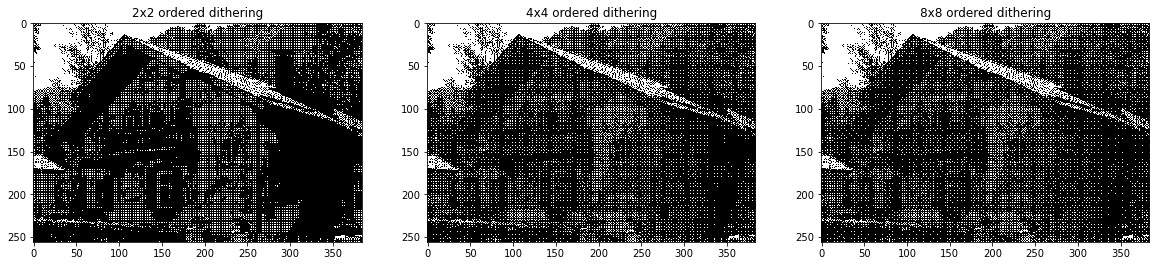

In [7]:
### Ordered Dithering:
#step 1 - open image
img = Image.open('house.tif') #PIL image
#convert img to numpy:
img_np = np.array(img) #note that I am re-opening the image, will overwrite previous exercise's variable. 

#step 2: Image has been gamma corrected, so, product a lin scale version:
gamma = 2.2
img_ungamma = 255 * (img_np/255) ** gamma

#step 3: create Bayer threshold matrices for sizes 2x2, 4x4, and 8x8:
IN = np.array([[1, 2], [3, 0]]) #basic 2 x 2 binary pixel grid in an "index matrix"
TN = 255 * ((IN + 0.5) / 4) #threshold matrix for 2 x 2
print('Bayer 2x2 index matrix:')
print(TN)

I2N = np.block([[4 * IN + 1, 4 * IN+2], [4 * IN + 3, 4 * IN]]) #4 x 4 binary pixel grid
T2N = 255 * ((I2N + 0.5) / 16) #threshold for 4 x 4
print('Bayer 4x4 index matrix:')
print(T2N)

I22N = np.block([[4 * I2N + 1, 4 * I2N + 2], [4 * I2N + 3, 4 * I2N]]) #8 x 8 binary pixel grid. 
T22N = 255 * ((I22N + 0.5) / 64)
print('Bayer 8x8 index matrix:')
print(T22N)

#step 4: Generate 3 different halftone images for house.tif by applyging the dither patterns to linear-scaled 
#img (i.e, the ungamma corrected). 
#note,  binary image can be produced from the threshold matrix via:
# pixel is 255 in binary image IF the original images's (i, j) px > threshold(i % N, j % N) (N can be 2, 4, 8)
# if threshold condition is not passed, then, px is 0! 

binary_imgN = np.zeros((img_ungamma.shape[0], img_ungamma.shape[1]))
binary_img2N = np.zeros((img_ungamma.shape[0], img_ungamma.shape[1]))
binary_img22N = np.zeros((img_ungamma.shape[0], img_ungamma.shape[1]))

for i in range(img_ungamma.shape[0]):
    for j in range(img_ungamma.shape[1]):
        if (img_ungamma[i,j] > TN[i % 2, j % 2]):
            binary_imgN[i,j] = 255
        if (img_ungamma[i,j] > T2N[i % 4, j % 4]):
            binary_img2N[i,j] = 255
        if (img_ungamma[i,j] > T22N[i % 8, j % 8]):
            binary_img22N[i,j] = 255

            
            

#step 5: export images to TIFF using imwrite
binary_imgN_PIL = Image.fromarray(binary_imgN)
binary_imgN_PIL.save("dithered_2x2.tif")

binary_img2N_PIL = Image.fromarray(binary_img2N)
binary_img2N_PIL.save("dithered_4x4.tif")

binary_img22N_PIL = Image.fromarray(binary_img22N)
binary_img22N_PIL.save("dithered_8x8.tif")


#step 6: for each of the halftone images, compute the RMSE and fidelity between the halftone and the original 
#image
# for the binary_imgN, RMSE:
print('stats for 2x2 ordered dithering halftoned image:')
computeRMSE(img_np, binary_imgN)
computeFidelity(img_np, binary_imgN,plot = 0, gamma=2.2)
print('\n')

# for the binary_img2N, RMSE and fidelity
print('stats for 4x4 ordered dithering halftoned image:')
computeRMSE(img_np, binary_img2N)
computeFidelity(img_np, binary_img2N,plot = 0, gamma=2.2)
print('\n')

#for the binary img22N, RMSE and fidelity:
print('stats for 8x8 ordered dithering halftoned image:')
computeRMSE(img_np, binary_img22N)
computeFidelity(img_np, binary_img22N,plot = 0, gamma= 2.2)

## Display the 3 halftoned images:
fig, ax = plt.subplots(1, 3, figsize=(20,20))

ax[0].imshow(255 * ((binary_imgN/255.0) ** (1/2.2)), interpolation='none', cmap = 'gray')
ax[0].set_title('2x2 ordered dithering')
ax[1].imshow(binary_img2N, interpolation= 'none', cmap = 'gray')
ax[1].set_title('4x4 ordered dithering')

ax[2].imshow(binary_img22N, interpolation = 'none', cmap='gray')
ax[2].set_title('8x8 ordered dithering')


[[0.     0.     0.    ]
 [0.     0.     0.4375]
 [0.1875 0.3125 0.0625]]
RMSE is 98.84985901290777
Fidelity is 25.270244737487417


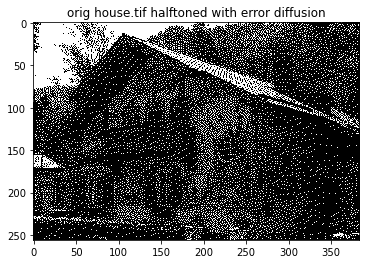

In [55]:
### Part 5: Error Diffusion

#Note, this algorithm needs to be applied to a linear scale version of house.tif. 
#Therefore, need work with the img_ungamma, which was already ungamma corrected using:
#255 * (gamma_corrected_px / 255) ** gamma. 

#We also need to work in raser order, which is pixels left to right, then, top to bottom.

#Part 1: Init an output matrix image with 0s
PIL_img = Image.open('house.tif')
np_img = np.uint8(PIL_img)
lin_img = 255 * ((np_img / 255.0) ** 2.2)
rows = np_img.shape[0]
cols = np_img.shape[1]
output_matrix = np.zeros((rows,cols))

diffusion_filter = np.array([[0, 0, 0], 
                             [0, 0, 7/16],
                             [3/16, 5/16, 1/16]])

print(diffusion_filter)
quantization_error_matrix = np.zeros((rows,cols))

#Part 2, 3, 4, 5: Quantize the current pixel to 0 or 255 using the threshold T = 127 (need to operate on img_ungamma!), compute the error
# between lin img and binary img, then, propogate that error using coefficients in Floyd/Steinberg filter to the next pixels in the linear img.
# then, repeat quantizing for next pixels in raster order based on the updated lineaer pixels! 
T = 127
for i in range(rows):
    for j in range(cols):
        if (lin_img[i,j] > T): #quantize based on threshold, placing result in output matrix
            output_matrix[i,j] = 255 
        #compute the quantization error by subtracting the binary pixel from grayscale:
        quantization_error_matrix[i,j] = lin_img[i,j] - output_matrix[i,j] #linear grayscale - binary

        #add scaled versions of this error using filter (only filtering if we are within an adequate boundary)
        #pass quantization error onto following pixels: [i, j+ 1] gets 7/16 * error added, [i+1, j-1] gets 3/16 of the error added, [i+1, j] gets 5/16 error added
        # and [i+1, j+1] gets 1/16 of the error added.       
        if (i > 0) and (j > 0) and (i < rows-1) and (j < cols-1):
            lin_img[i, j+1] = lin_img[i,j+1] + (diffusion_filter[1,2] * quantization_error_matrix[i,j])
            lin_img[i+1, j-1] = lin_img[i + 1, j - 1] + (diffusion_filter[2,0] * quantization_error_matrix[i,j])
            lin_img[i+1, j] = lin_img[i+1, j] + (diffusion_filter[2,1] * quantization_error_matrix[i,j])
            lin_img[i+1, j+1] = lin_img[i+1, j+1] + (diffusion_filter[2,2] * quantization_error_matrix[i,j])

plt.imshow(output_matrix, cmap='gray', interpolation='none')
plt.title('orig house.tif halftoned with error diffusion')

# Compute RMSE
computeRMSE(np.uint8(np_img), output_matrix)
computeFidelity(np_img, output_matrix, plot=0, gamma=2.2)

#save to tiff:
binary_diffused = Image.fromarray(output_matrix)
binary_diffused.save("binary_diffused.tif")
#